## Prepare data
50% training data, 25% validation data and 25% testing data

In [14]:
import numpy as np
from scipy.io import loadmat
from keras.preprocessing import sequence
from keras.utils import to_categorical


X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for action in range(1, 28):
    # print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = f'Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
            try:
                data = loadmat(filename)['d_iner']
            except:
                continue
            
            # if data is None: continue
            data = np.swapaxes(data, 0, 1)
            data = sequence.pad_sequences(data, maxlen=326)

            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                Y_val.append(action-1)
            else:
                X_test.append(data)
                Y_test.append(action-1)
                
X_train1 = np.array(X_train)
Y_train = np.array(Y_train)
X_val1 = np.array(X_val)
Y_val = np.array(Y_val)
X_test1 = np.array(X_test)
Y_test = np.array(Y_test)
Y_label_test = Y_test

X_train1 = np.swapaxes(X_train1, 1, 2)
X_val1 = np.swapaxes(X_val1, 1, 2)
X_test1 = np.swapaxes(X_test1, 1, 2)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

print('X_train.shape:', X_train1.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val1.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test1.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (431, 326, 6)
Y_train.shape: (431, 27)
X_val.shape: (215, 326, 6)
Y_val.shape: (215, 27)
X_test.shape: (215, 326, 6)
Y_test.shape: (215, 27)


In [3]:
from cv2 import resize

X_train = []
X_val = []
X_test = []

for action in range(1, 28):
    # print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = f'Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
            try:
                data = loadmat(filename)['d_skel']
            except:
                continue
            
            # not right
            # data = data.reshape(60, data.shape[2])
            data2 = data[:,0,:]
            for n in range(1,3):
                data2 = np.vstack((data2, data[:,n,:]))
            data = data2
            
            # normalize coord into image pixel
            data = np.floor((data-data.min()) / (data.max()-data.min()) * 255) 
            data = resize(data, (60, 60))
            # data = sequence.pad_sequences(data, maxlen=125)
            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                # Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                # Y_val.append(action-1)
            else:
                X_test.append(data)
                # Y_test.append(action-1)
                
X_train2 = np.array(X_train)
X_val2 = np.array(X_val)
X_test2 = np.array(X_test)

X_train2 = np.expand_dims(X_train2, axis=3)
X_test2 = np.expand_dims(X_test2, axis=3)
X_val2 = np.expand_dims(X_val2, axis=3)

print('X_train.shape:', X_train2.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val2.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test2.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (431, 60, 60, 1)
Y_train.shape: (431, 27)
X_val.shape: (215, 60, 60, 1)
Y_val.shape: (215, 27)
X_test.shape: (215, 60, 60, 1)
Y_test.shape: (215, 27)


Processing of video and depth data please refer to 03_video.ipynb

In [4]:
mat_depth = np.load('depth_of.npz')
mat_video = np.load('video_of.npz')

X_train3 = mat_depth['arr_0']
X_val3 = mat_depth['arr_2']
X_test3 = mat_depth['arr_4']
X_train4 = mat_video['arr_0']
X_val4 = mat_video['arr_2']
X_test4 = mat_video['arr_4']

print(X_train3.shape)
print(X_val3.shape)
print(X_test3.shape)
print(X_train4.shape)
print(X_val4.shape)
print(X_test4.shape)

(431, 64, 64, 20)
(215, 64, 64, 20)
(215, 64, 64, 20)
(431, 64, 64, 20)
(215, 64, 64, 20)
(215, 64, 64, 20)


### References

## Multimodal fusion of 4 models

In [6]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, Conv2D, Dropout, Flatten, Activation, Dense, LSTM, Input, concatenate
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=5, verbose=1, monitor='val_acc')
checkpointer = ModelCheckpoint('model_f.h5', verbose=0, save_best_only=True)

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (64, 64, 20), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn.add(Flatten())
# 256 for testing, otherwise use 2048
simple_cnn.add(Dense(1024, activation='relu'))
simple_cnn.add(Dropout(0.7))


simple_cnn2 = Sequential()
simple_cnn2.add(BatchNormalization(input_shape = (64, 64, 20), 
                                  name = 'NormalizeInput'))
simple_cnn2.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn2.add(MaxPooling2D((2, 2) , strides = 2))
simple_cnn2.add(Flatten())
# 256 for testing, otherwise use 2048
simple_cnn2.add(Dense(1024, activation='relu'))
simple_cnn2.add(Dropout(0.7))

kernel_size = 3 
pool_size = 2
dropout_rate = 0.15
f_act = 'relu'

model1 = Sequential()
model1.add(Conv1D(64, (kernel_size), input_shape=X_train1.shape[1:], 
                       activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))

model1.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=(pool_size)))

model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(128))
model1.add(Dropout(0.5))


model2 = Sequential()
model2.add(BatchNormalization(input_shape = X_train2.shape[1:], 
                                  name = 'NormalizeInput'))
model2.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model2.add(MaxPooling2D((3, 3) , strides = 2))
model2.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model2.add(Flatten())
model2.add(Dropout(0.5))


# create tensors
inertial_input = Input(shape=(326, 6))
encoded_int = model1(inertial_input)
skeleton_input = Input(shape=(60, 60, 1))
encoded_skt = model2(skeleton_input)
depth_input = Input(shape=(64, 64, 20))
encoded_dpt = simple_cnn(depth_input)
video_input = Input(shape=(64, 64, 20))
encoded_vd = simple_cnn2(video_input)

merged = concatenate([encoded_int, encoded_skt, encoded_dpt, encoded_vd])
output = Dense(27, activation='softmax')(merged)
model = Model(inputs=[inertial_input, skeleton_input, depth_input, video_input], outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit([X_train1, X_train2, X_train3, X_train4], Y_train,
                    batch_size=64,
                    validation_data=([X_val1, X_val2, X_val3, X_val4], Y_val), 
                    epochs=30, verbose = 2, 
                    callbacks = [earlystopper])

Train on 431 samples, validate on 215 samples
Epoch 1/30
 - 35s - loss: 5.7795 - acc: 0.0348 - val_loss: 3.2458 - val_acc: 0.0791
Epoch 2/30
 - 20s - loss: 3.1516 - acc: 0.1299 - val_loss: 3.0063 - val_acc: 0.2326
Epoch 3/30
 - 22s - loss: 2.8545 - acc: 0.2181 - val_loss: 2.6736 - val_acc: 0.2186
Epoch 4/30
 - 21s - loss: 2.4460 - acc: 0.3527 - val_loss: 2.1782 - val_acc: 0.4326
Epoch 5/30
 - 22s - loss: 1.8688 - acc: 0.4710 - val_loss: 1.8476 - val_acc: 0.4419
Epoch 6/30
 - 19s - loss: 1.4096 - acc: 0.6032 - val_loss: 1.3721 - val_acc: 0.6605
Epoch 7/30
 - 19s - loss: 0.8763 - acc: 0.7633 - val_loss: 1.0233 - val_acc: 0.7349
Epoch 8/30
 - 19s - loss: 0.6842 - acc: 0.8028 - val_loss: 0.9696 - val_acc: 0.7163
Epoch 9/30
 - 19s - loss: 0.4470 - acc: 0.8933 - val_loss: 0.8830 - val_acc: 0.7163
Epoch 10/30
 - 19s - loss: 0.3058 - acc: 0.9304 - val_loss: 0.8411 - val_acc: 0.7721
Epoch 11/30
 - 19s - loss: 0.2434 - acc: 0.9327 - val_loss: 0.8037 - val_acc: 0.7628
Epoch 12/30
 - 20s - loss: 0

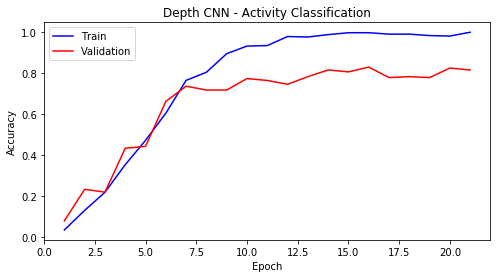

In [9]:
import matplotlib.pyplot as plt

epoch = list(range(1,22))
plt.figure(figsize=(8,4))
plt.plot(epoch, history.history['acc'], color='b')
plt.plot(epoch, history.history['val_acc'], color='r')
plt.title('Depth CNN - Activity Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

In [11]:
# Evaluate model
scores = model.evaluate([X_test1, X_test2, X_test3, X_test4], Y_test, verbose=2)
print("Loss: %.2f" % scores[0])
print("Accuracy: %.2f%%" % (scores[1]*100))

Loss: 0.63
Accuracy: 81.86%


## Model plot

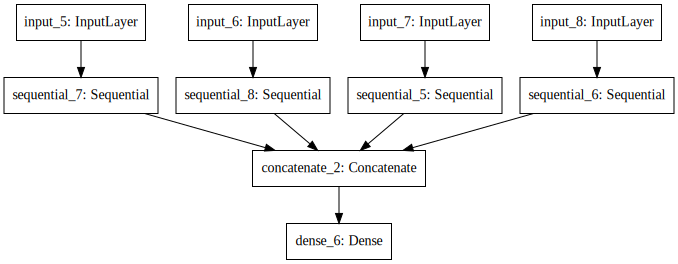

In [12]:
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_fusion.png', show_shapes = True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
from sklearn.metrics import confusion_matrix

pred = model.predict([X_test1, X_test2, X_test3, X_test4], batch_size=64, verbose = 2)
y_class = pred.argmax(axis=-1)
cnf_matrix = confusion_matrix(Y_label_test, y_class)
cnf_matrix.shape

(27, 27)

In [16]:
# https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


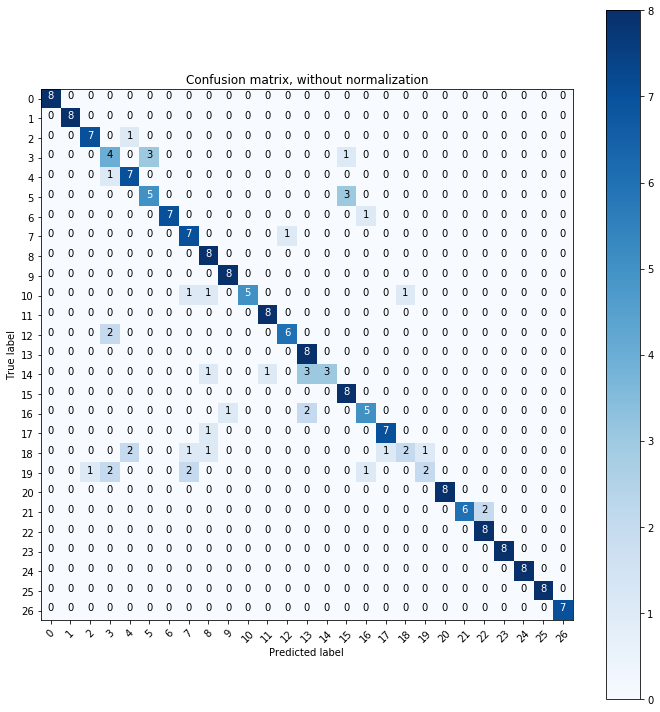

In [17]:
class_names = list(range(27))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()